In [36]:
import pandas as pd
import numpy as np
import pprint as pp
import pgeocode as pg
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
import smogn
import datetime

warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('train.csv')
df.head()

,Id,Tipo,FechaConstruccion,FechaReforma,Plantas,Plan,PAU,CatParcela,PerimParcela,Superficie,...,AguaCorriente,FosaSeptica,Situacion,CP,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,Precio
0,1,Chalet individual,2003,2003,2,Antiguo,0,Residencial unifamiliar,79.25,785.03,...,1,0,Interior,60061,0,0,0,5,3.5,375497
1,2,Chalet individual,1976,1976,1,Antiguo,0,Residencial unifamiliar,97.54,891.87,...,1,0,Frontal 2 lados,50018,0,1,0,8,3.0,339946
2,3,Chalet individual,2001,2002,2,Antiguo,0,Residencial unifamiliar,82.91,1045.16,...,1,0,Interior,60061,0,0,0,5,3.5,402511
3,4,Chalet individual,1915,1970,2,Nuevo,0,Residencial unifamiliar,73.15,887.22,...,1,0,Esquina,62451,0,0,0,5,3.5,272706
4,5,Chalet individual,2000,2000,2,Antiguo,0,Residencial unifamiliar,102.41,1324.80,...,1,0,Frontal 2 lados,60706,0,0,0,5,4.0,450236


In [38]:
def visualize_dataframe_distributions(df):
    # Filtering columns by data type
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Total number of columns
    side_length = int(np.ceil(np.sqrt(n)))  # Calculating grid side length
    
    # Creating the subplot grid
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

In [39]:
variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']
print('Variables reales: ', variables_reales)
print('Variables categoricas: ', variables_categoricas)
print('Variables enteras: ', variables_enteras)

Variables reales:  Index(['PerimParcela', 'Superficie', 'RatingEstrellas'], dtype='object')
Variables categoricas:  Index(['Tipo', 'Plan', 'CatParcela', 'Formato', 'TipoDesnivel', 'Desnivel',
       'Situacion'],
      dtype='object')
Variables enteras:  Index(['Id', 'FechaConstruccion', 'FechaReforma', 'Plantas', 'PAU', 'Aseos',
       'Habitaciones', 'Garaje', 'Piscina', 'Vallada', 'CallePavimentada',
       'Callejon', 'GasNatural', 'AguaCorriente', 'FosaSeptica', 'CP',
       'ProxCarretera', 'ProxCallePrincipal', 'ProxViasTren', 'Estado',
       'Precio'],
      dtype='object')


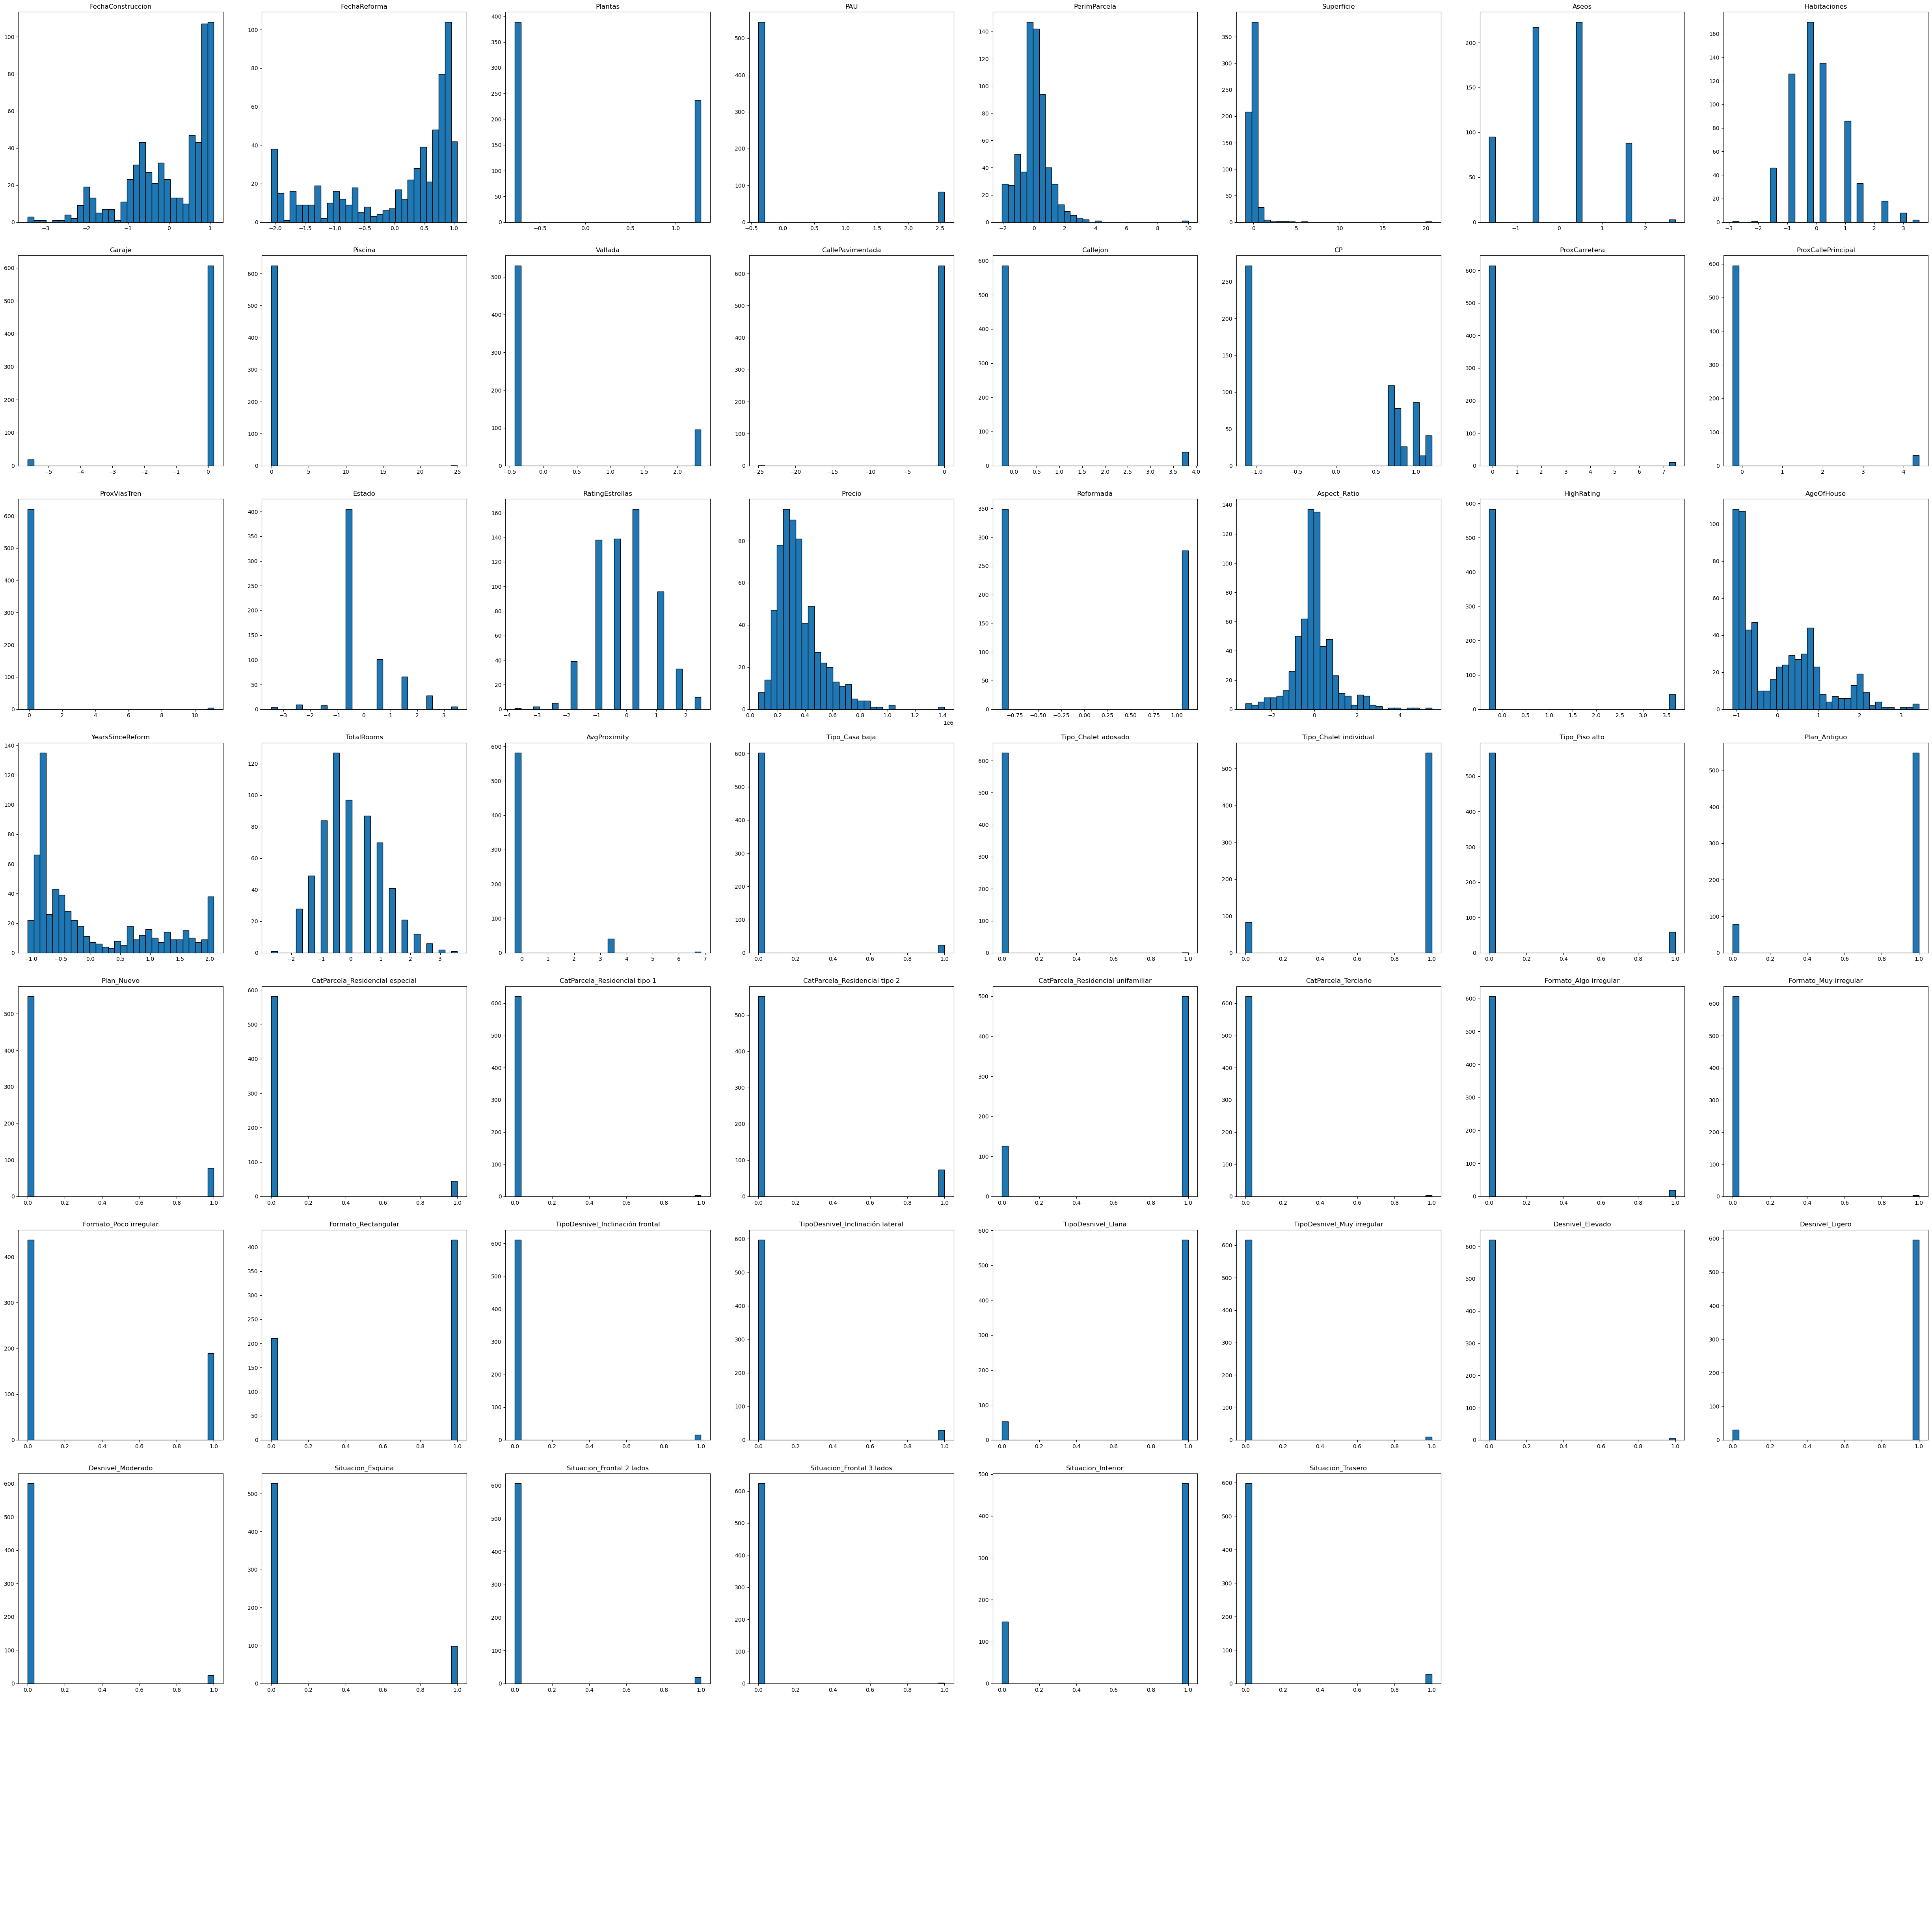

In [40]:
def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[:3]
    df['specific_location'] = df['CP']
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

#df.drop('Id', inplace=True, axis=1)
df.drop(['Id', 'AguaCorriente', 'GasNatural', 'FosaSeptica'], axis=1, inplace=True)
df.dropna(inplace=True)
# #df = extract_postal_hierarchy(df)

df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
df['Reformada'] = df['Reformada'].astype(int)

# # Assuming you've already loaded your dataframe as df

# Current Year
current_year = datetime.datetime.now().year
df['Aspect_Ratio'] = df['PerimParcela'] / df['Superficie']
df['HighRating'] = df['RatingEstrellas'].apply(lambda x: 1 if x > 4 else 0)
df['AgeOfHouse'] = current_year - df['FechaConstruccion']
df['YearsSinceReform'] = current_year - df['FechaReforma']
df['TotalRooms'] = df['Aseos'] + df['Habitaciones']
df['AvgProximity'] = (df['ProxCarretera'] + df['ProxCallePrincipal'] + df['ProxViasTren']) / 3

variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']

variables_enteras = variables_enteras.drop(['Precio'])
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)
# df = zscore_norm_price(df)
df = one_hot_encoding(df, variables_categoricas)
df.dropna(inplace=True)
visualize_dataframe_distributions(df)

                                    FechaConstruccion  FechaReforma   Plantas   
FechaConstruccion                            1.000000      0.612870  0.129108  \
FechaReforma                                 0.612870      1.000000  0.187568   
Plantas                                      0.129108      0.187568  1.000000   
PAU                                          0.200842      0.094040  0.048371   
PerimParcela                                 0.124856      0.086501 -0.038367   
Superficie                                   0.025292      0.003071 -0.021736   
Aseos                                        0.556998      0.456710  0.519252   
Habitaciones                                 0.314723      0.327197  0.516421   
Garaje                                       0.185517      0.139069  0.138096   
Piscina                                     -0.006657      0.019347 -0.031222   
Vallada                                     -0.277684     -0.199550 -0.094555   
CallePavimentada            

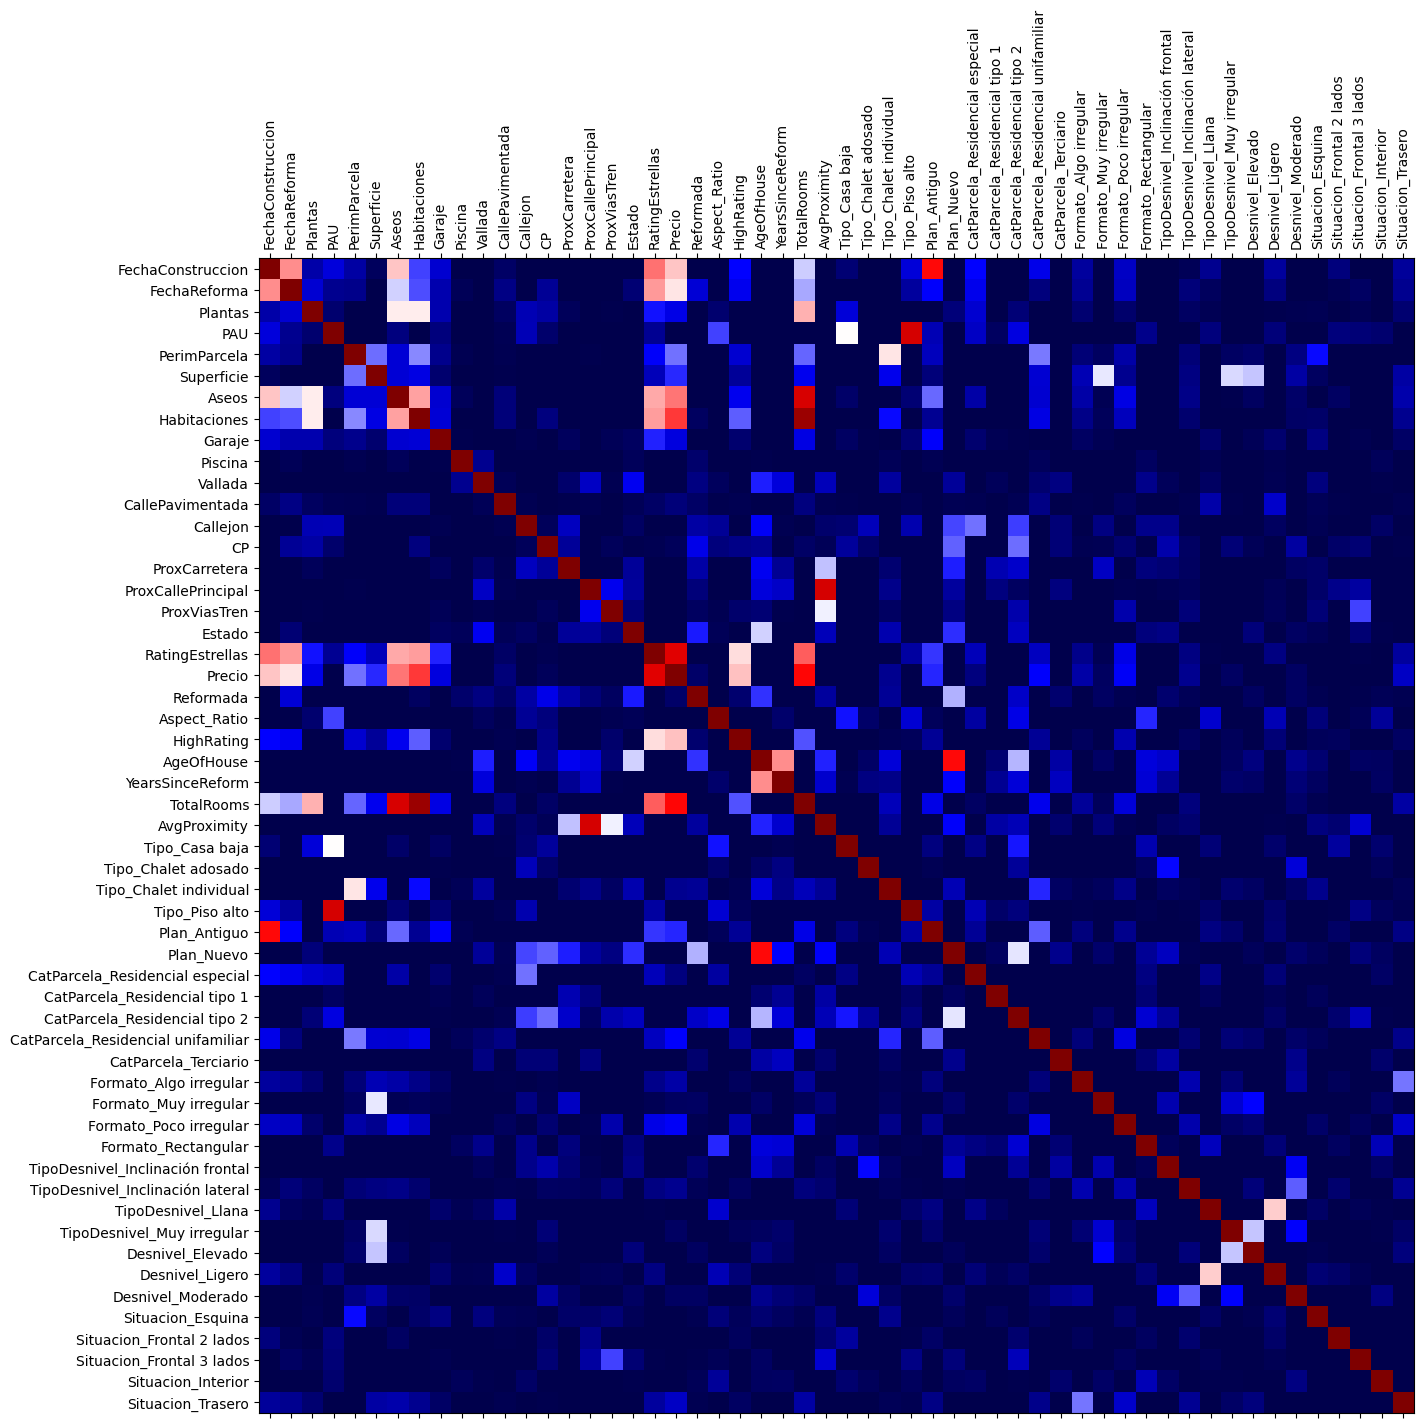

In [41]:
# plot correlation matrix of columns in the dataframe
def plot_correlation_matrix(df):
    corr = df.corr()
    #sort the correlation, place the most correlated variables next to price
    print(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

plot_correlation_matrix(df)

In [42]:

# corr = df.corr()
# umbral = 0.5
# # Encontrar características altamente correlacionadas
# caract_alta_correlacion = set()
# for i in range(len(corr.columns)):
#     for j in range(i):
#         if abs(corr.iloc[i, j]) > umbral:
#             colname = corr.columns[i]
#             caract_alta_correlacion.add(colname)
# caract_alta_correlacion.remove('Precio')
# # Eliminar características altamente correlacionadas
# print(caract_alta_correlacion)
# df = df.drop(caract_alta_correlacion, axis=1)
# df

In [43]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

train_size = 0.8
train = df.sample(frac=train_size, random_state=0)
test = df.drop(train.index)

train = train.reset_index(drop=True)

#train = smogn.smoter(data = train, y = 'Precio', k=20)

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')

pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# X_train['Categoria'] = kmeans.fit_predict(X_train)
# X_train = pd.get_dummies(X_train, columns=['Categoria'], dtype=np.int64)
# X_test['Categoria'] = kmeans.fit_predict(X_test)
# X_test = pd.get_dummies(X_test, columns=['Categoria'], dtype=np.int64)

In [44]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred

def visualize_test(y_test, y_pred, ax, model_name):
    paired = sorted(list(zip(y_test, y_pred)))
    y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    # print in scientific notation format
    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))
    # plot y_test and y_pred values to visualize the model performance
    num_range = np.arange(0, len(y_test))
    ax.plot(y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()

In [45]:
# from sklearn.preprocessing import StandardScaler

# data_train = train
# kmeans = KMeans(n_clusters=3, random_state=42)
# data_train['Categoria'] = kmeans.fit_predict(X_train)

# Q1 = data_train['Precio'].quantile(0.10)
# Q3 = data_train['Precio'].quantile(0.9)
# IQR = Q3 - Q1
# low_threshold = Q1 - 1.5 * IQR
# high_threshold = Q3 + 1.5 * IQR

# counts = data_train['Categoria'].value_counts()

# # Calcular la media de cada categoría
# means = data_train.groupby('Categoria')['Precio'].mean()

# # Imprimir los resultados
# print("Cantidad de casas en cada categoría:")
# print(counts)
# print("\nMedia de precios en cada categoría:")
# print(means)

# variables_categoricas = data_train.dtypes[data_train.dtypes == 'object'].index
# data_train = pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

# X_train, y_train = x_y_split(data_train, 'Precio')
# X_test, y_test = x_y_split(test, 'Precio')

# models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# # cols and rows for subplots according to number of models
# fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

# for i, model in enumerate(models):
#         model_name = model.__class__.__name__
#         trained_model = train_model(model, X_train, y_train)
#         y_pred = test_model(trained_model, X_test, y_test)
#         visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

MAE: 60.912118270327866
MAPE: 17.63


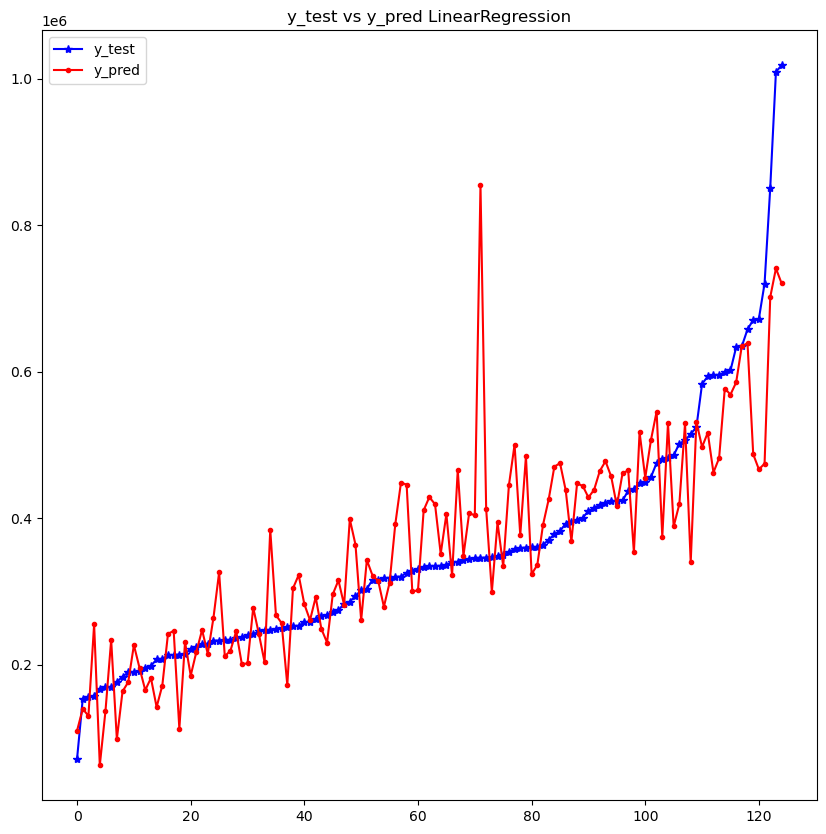

In [46]:
best_combination = {'recall': 0, 'model': None, 'norm': None, 'sampling': None, 'trained_model': None}
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)

MAE: 60.912118270327866
MAPE: 17.63
MAE: 59.5488693050231
MAPE: 16.62
MAE: 60.91186616166476
MAPE: 17.63
MAE: 60.90018549349213
MAPE: 17.62
MAE: 57.520008
MAPE: 16.64
MAE: 50.00731883999999
MAPE: 14.89
MAE: 51.09495052361423
MAPE: 15.25
MAE: 57.749597543421054
MAPE: 17.1


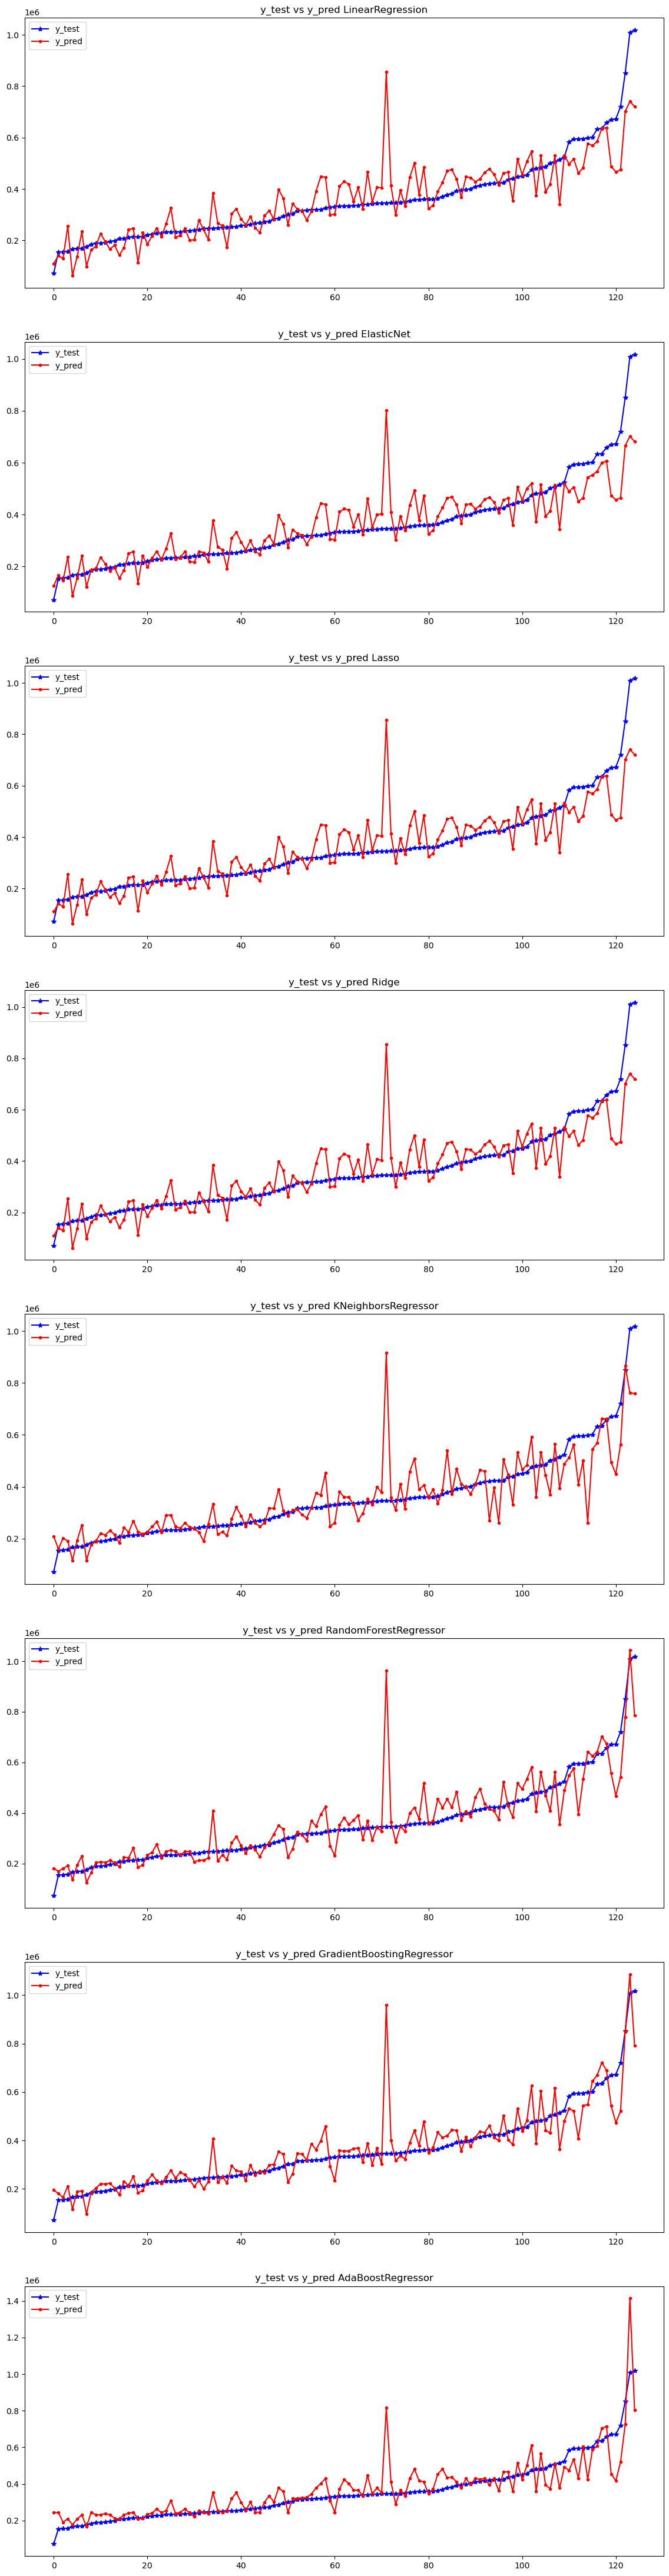

In [47]:
models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

plt.show()


In [48]:
grad_boost = GradientBoostingRegressor()

distributions = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 7),
    'min_samples_split': uniform(0.01, 0.2),
    'min_samples_leaf': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=10000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


KeyboardInterrupt: 

MAE: 4.45e+04


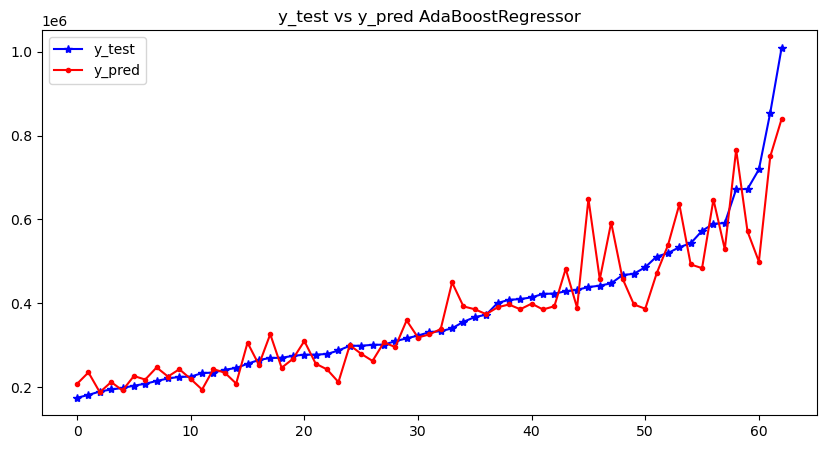

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)